## Prawesh Dahal
### Speech Emotion Recognition
#### Part II - RNN-Bi-LSTM with ATTENTION

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import librosa
import scipy
from scipy.io import wavfile
import os, time, csv, datetime
from librosa import display
import matplotlib.pyplot as plt 
from numpy import diff
import h5py
from tqdm import tqdm_notebook as tqdm 
from tqdm import tnrange as trange 

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 

In [3]:
#Get inside directory 
parent_dir = os.getcwd()
dataset_dir = os.path.join(parent_dir,'drive/My Drive/COLUMBIA 2023/Spring 2019/ELEN 6820 Speech Proc/RAVDESS')
print(parent_dir)
print(dataset_dir)

/content
/content/drive/My Drive/COLUMBIA 2023/Spring 2019/ELEN 6820 Speech Proc/RAVDESS


In [4]:
os.listdir(dataset_dir)

['0', 'Readme.txt', '1', '2', '3', '4', '5', '6', '7']

In [0]:
length_wave_max = 85346 #maximum length of the audio waves
 
emo_label ={0: 'neutral', 1:'calm', 2: 'happy',
            3: 'sad',   4: 'angry', 5: 'fearful',
            6: 'disgust', 7: 'surprise'}

features = []
labels  = []
max_frame_len = 442 #maximum length of the audio waves
emotionset = [0, 2, 3, 4]
currpath = '/content/drive/My Drive/COLUMBIA 2023/Spring 2019/ELEN 6820 Speech Proc/'


### Hyperparameters

In [77]:
import torch 
import argparse
import os

# make a name for this experiment
exp_name = 'Project_RNN'  # change it as you like!

# make a directory for the experiment
if not os.path.exists(exp_name):
    os.makedirs(exp_name)
parser = argparse.ArgumentParser(description=exp_name)

# add hyperparameters to the parser
parser.add_argument('--batch-size', type=int, default=8,
                    help='input batch size for training (default: 8)') #typically choose batch_size to be 8

parser.add_argument('--epochs', type=int, default=100,
                    help='number of epochs to train (default: 100)') #take 100 epochs

parser.add_argument('--freq-dim', type=int, default=128,
                    help='the frequency dimension (default: 128)') #there are 128 frequency values

#The output should be 5 one-hot coded vectors emotions
parser.add_argument('--emotions-dim', type=int, default=5,
                    help='emotions dimension (default: 5)')  #there are 5 emotions in total 

parser.add_argument('--cuda', action='store_true', default=True,
                    help='enables CUDA training (default: True)')  # when you have a GPU

parser.add_argument('--lr', type=float, default=1e-3,
                    help='learning rate (default: 1e-3)') #learning rate

parser.add_argument('--model-save', type=str,  default='best_model.pt',
                    help='path to save the best model')   #name to save the model

parser.add_argument('--tr-data', type=str,  default='tr_melset.hdf5',
                    help='path to training dataset')  #to store the training dataset

parser.add_argument('--val-data', type=str,  default='val_melset.hdf5',
                    help='path to validation dataset') #to store validation dataset

parser.add_argument('--test-data', type=str,  default='test_melset.hdf5',
                    help='path to test dataset')  #to store test dataset 

args, _ = parser.parse_known_args()
args.cuda = args.cuda and torch.cuda.is_available()

if args.cuda:
    kwargs = {'num_workers': 1, 'pin_memory': True} 
    %env CUDA_VISIBLE_DEVICES = 1
    print(torch.cuda.get_device_name(0))
else:
    kwargs = {}

env: CUDA_VISIBLE_DEVICES=1
Tesla T4


In [78]:
nb_classes = 5
targets = np.array([[0, 1, 2, 3, 4]]).reshape(-1)
one_hot_targets = np.eye(nb_classes)[targets]
print(one_hot_targets)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [79]:
## Verify if one-hot encoding works: 
 
val_name = 'val_melset.hdf5'

 

val_dataset = h5py.File(currpath+val_name, 'a')

val_spec_sample = val_dataset['emotions']  

last_lab = val_spec_sample[4]

one_hot_label = torch.from_numpy(one_hot_targets[last_lab,:])

print('Emotion is', last_lab)
print('Its one-hot label is', one_hot_label)

print(val_spec_sample.shape)


Emotion is [0]
Its one-hot label is tensor([[1., 0., 0., 0., 0.]], dtype=torch.float64)
(56, 1)


### Data Loading Pipeline

In [0]:
#data loading functions 
import argparse
import torch
from torch.utils.data import Dataset, DataLoader

class dataset_pipeline(Dataset):
    def __init__(self, path):
        super(dataset_pipeline, self).__init__()

        self.h5pyLoader = h5py.File(currpath+path, 'r')
        
        #From each dataset - extract all spectrograms and emotions        
        self.spec = self.h5pyLoader['spec']
        self.emotions = self.h5pyLoader['emotions']
         
        self._len = self.spec.shape[0]  #number of training set of audios
        
    def __getitem__(self, index):
        spec_item = torch.from_numpy(self.spec[index].astype(np.float32))        
        
        emotion_makehot = self.emotions[index]        
        
        emotions_item = torch.from_numpy(one_hot_targets[emotion_makehot,:])
        
        len_of_data = self._len
            
        return spec_item, emotions_item, len_of_data 
    
    def __len__(self):
        return self._len
    
# define data loaders
#TRAINING 
train_loader = DataLoader(dataset_pipeline(args.tr_data), 
                          batch_size=args.batch_size, 
                          shuffle=True, 
                          **kwargs)

#VALIDATION
validation_loader = DataLoader(dataset_pipeline(args.val_data), 
                               batch_size=args.batch_size, 
                               shuffle=False, 
                               **kwargs)

#TEST
test_loader = DataLoader(dataset_pipeline(args.test_data), 
                               batch_size=args.batch_size, 
                               shuffle=False, 
                               **kwargs)

args.dataset_len = len(train_loader)
args.log_step = args.dataset_len // 4


### LSTM Model

In [89]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

 
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        
        self.hidden_unit = 128   
        
        #------------------------------------------
        # ATTENTION 
        
        self.attn = nn.Linear(self.hidden_unit * 6, self.hidden_unit*2)
        self.attn_combine = nn.Linear(self.hidden_unit * 4, self.hidden_unit*2)
        #self.dropout = nn.Dropout(self.dropout_p)
        #self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_unit*2, args.emotions_dim)
        
        
        
        #---------------------------------------------------
        # LAYER 1 - input layer
        self.lstm_layer = nn.LSTM(input_size=args.freq_dim,
                                  hidden_size=self.hidden_unit,
                                  num_layers=1,
                                  dropout = 0.3, 
                                  batch_first=True,
                                  bidirectional=True)
        
        #-----------------------------------------------------
        # OUTPUT 
        self.output_linear = nn.Sequential(nn.Linear(self.hidden_unit*2, args.emotions_dim),nn.Softmax(dim=1))
        
        #-----------------------------------------------------
        
    def forward(self, input):
 
        batch_size = input.size(0)
        freq = input.size(1)
        num_frame = input.size(2)
        
        input = input.transpose(1, 2).contiguous()  # (batch, time, freq)        
#         print('LSTM Input', input.size())
        
        # pass it through layers
        output, (h_n, c_n) = self.lstm_layer(input)  # (batch, time, freq)
      
#         print('LSTM output h_n',h_n.size())
#         print('LSTM output c_n',c_n.size())
#         print('LSTM output 1',output.size())
       
        last_output = torch.cat((h_n, c_n), 2)
        last_output = last_output.view(batch_size,-1)
        
#         print('Last output', last_output.size())
        
        fin_output = output[:, -1, :]
#         print('Fin output', fin_output.size())
        
        output_main = torch.cat((last_output, fin_output),1)
#         print('LSTM Conc Output', output_main.size())   

#         output = self.output_linear(fin_output)
#         print('Last Frame Out', output.size())
  
        #------------------ATTENTION-----------------------------
        

        
        attn_conc = self.attn(output_main)
#         print('Attn Conc',attn_conc.size())
        
        attn_weights = F.softmax(attn_conc, dim=1)
#         print('Att W', attn_weights.size())

        attn_applied = torch.mul(attn_weights,fin_output)
#         print('Att Ap', attn_applied.size())

        output = torch.cat((fin_output, attn_applied), 1)
#         print('Conc',output.size())
        
        output = self.attn_combine(output)
#         print('Concattn',output.size())

        #output = F.relu(output)
         

        output = F.softmax(self.out(output), dim=1)
        
#         print('LSTM Final Output!!', output.size()) 

 
        return output
    
# the model and the optimizers
model_LSTM = LSTM()
print(model_LSTM) 

# define the optimizer
optimizer = optim.Adam(model_LSTM.parameters(), lr=args.lr)
scheduler  = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
scheduler.step()

LSTM(
  (attn): Linear(in_features=768, out_features=256, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=5, bias=True)
  (lstm_layer): LSTM(128, 128, batch_first=True, dropout=0.3, bidirectional=True)
  (output_linear): Sequential(
    (0): Linear(in_features=256, out_features=5, bias=True)
    (1): Softmax()
  )
)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


### Classification Accuracy

In [0]:
def classaccu(actual_emotions,output_emotions):    
    
    # the label index for the predicted output probability
#     print('Acc: Output Labels',output_emotions.size(), output_emotions.type(), output_emotions)
#     print('Acc: Actual Labels', actual_emotions.size(), actual_emotions.type(), actual_emotions)
  
    actual_label_index = torch.argmax(actual_emotions, dim=2)  
    actual_label_index = actual_label_index[:,0] 

#     print('Acc: Actual Labels index', actual_label_index.size(), actual_label_index.type(), actual_label_index)

       
    # the label index for the actual label
    output_emotions = output_emotions.cpu()
    output_label_index = torch.argmax(output_emotions, dim=1)
    
#     print('Acc: Output Labels index',output_label_index.size(),output_label_index.type(), output_label_index)     
      
    # the number of correctly labeled frames
    correct_frame = torch.sum(output_label_index == actual_label_index)
    
#     print(correct_frame.item())
    
    
#     print('correct frame', correct_frame)    
    return correct_frame

### Optimizer

In [0]:
#Adam Optimizer 
optimizer = optim.Adam(model_LSTM.parameters(), lr=args.lr)
 
scheduler  = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)
scheduler.step()

### Focal Loss

In [0]:
def Focal_Loss(actual_emotions,output_emotions, gamma=1, eps=1e-16):
    
    pt =  output_emotions 
#     print('FL output emotions (pt)',pt)
#     print('FL output emotions (pt)',pt.size(), pt.type())

    actual_emotions = actual_emotions.type(torch.FloatTensor)
    actual_emotions = actual_emotions.cuda()
    actual_emotions = torch.squeeze(actual_emotions)
#     print('FL actual emotions', actual_emotions)
#     print('FL actual emotions', actual_emotions.size(), actual_emotions.type())

           
    log_pt = (pt+eps).log()
    #print('probs size= {}'.format(probs.size()))
#     print('Log pt', log_pt)

    batch_loss = -1*(torch.pow(1-pt, gamma)*actual_emotions*log_pt)
#     print('Batch FL', batch_loss.size(), batch_loss)

    loss = batch_loss.sum(1).mean()
#     print('Mean FL', loss)
    
    return loss

### Training Function

In [0]:
def train(model,versatile=True):
    start_time = time.time()
    model = model.train()  # set the model to training mode
    train_loss = 0.
    train_acc = 0.
    
    # load batch data - data contains - spec and emotion label  
    #batch_spec => spec of data
    #batch_emotions => emotions of that batch
     
        
    for batch_idx, (batch_spec, batch_emotions, data_lenn) in enumerate(train_loader):
            
        # clean up the gradients in the optimizer - should be called for each batch
        optimizer.zero_grad()
        
        #--------------------------------------------------------------------------
        #Feed in spectrogram to the model 
        
        batch_output = model(batch_spec.cuda())
        tr_data_len = data_lenn.data.numpy()
         
         
        #-------------------------------------------------------------------------
        
        # Calculate the training loss 
 
        loss = Focal_Loss(batch_emotions,batch_output)
        t_acc = classaccu(batch_emotions,batch_output)
                       
        
        # automatically calculate the backward pass
        loss.backward()
        # perform the actual back-propagation
        optimizer.step()
        
        train_loss += loss.data.item()
        train_acc += t_acc.data.item()
        
        # OPTIONAL: you can print the training progress 
        if versatile:
            if (batch_idx+1) % args.log_step == 0:
                elapsed = time.time() - start_time
                print('| epoch {:3d} | {:5d}/{:5d} batches | ms/batch {:5.2f} | Focal Loss {:5.4f} |'.format(
                    epoch, batch_idx+1, len(train_loader),
                    elapsed * 1000 / (batch_idx+1), 
                    train_loss / (batch_idx+1)
                    ))
    
    train_loss /= (batch_idx+1)
    train_acc /= tr_data_len[0]   #479 or 1027
    print('-' * 99)
    print('    | end of training epoch {:3d} | time: {:5.2f}s | Focal loss {:5.4f} |'.format(
            epoch, (time.time() - start_time), train_loss))
    
    return train_loss, train_acc


#### Validating Function

In [0]:
def validate(model,loader = validation_loader):
    start_time = time.time()
    model = model.eval()  # set the model to evaluation mode, this is important if you have BatchNorm in your model!
    validation_accuracy = 0.
    validation_loss = 0.
    
    # load batch data
    for batch_idx, (batch_spec, batch_emotions, data_lenn) in enumerate(validation_loader):
         
        
        # you don't need to calculate the backward pass and the gradients during validation
        # so you can call torch.no_grad() to only calculate the forward pass, save time and memory
        
        with torch.no_grad():
            
            ############################################################################
            #Validate the model 
            
            batch_output = model(batch_spec.cuda())
            val_data_len = data_lenn.data.numpy()
            
            ###########################################################################
        
            # Classification Accuracy 
            val_loss = Focal_Loss(batch_emotions,batch_output)
            val_acc = classaccu(batch_emotions,batch_output)
        
            validation_accuracy += val_acc.data.item()
            validation_loss += val_loss.data.item()
    
    validation_loss /= (batch_idx+1)
    validation_accuracy /= val_data_len[0] #56 or 120 
    print('    | end of validation epoch {:3d} | time: {:5.2f}s | Accuracy {:5.4f} | | Loss {:5.4f} |'.format(
            epoch, (time.time() - start_time), validation_accuracy, validation_loss))
    print('-' * 99)
    
    return validation_loss, validation_accuracy

#### TRAIN THE MODEL


In [95]:
#MAIN FUNCTION
training_loss = []
training_accu = []
validation_loss = []
validation_acc = []


decay_cnt = 0
for epoch in trange(1,args.epochs + 1):
    if args.cuda:
        model_LSTM = model_LSTM.cuda()
     
    # TRAIN AND VALIDATE THE MODEL - COLLECT THE LOSS and ACCURACY for each EPOCH
    tr_loss, tr_accu = train(model_LSTM)
    training_loss.append(tr_loss)
    training_accu.append(tr_accu)
  
    v_loss, v_accu = validate(model_LSTM)
    validation_loss.append(v_loss)
    validation_acc.append(v_accu)
    
    if training_loss[-1] == np.min(training_loss):
        print('Best training model found.')
    if validation_acc[-1] == np.max(validation_acc):
        # save current best model
        with open(args.model_save, 'wb') as f:
            torch.save(model_LSTM.cpu().state_dict(), f)
            print('Best validation model found and saved.')
    
    print('-' * 99)
    decay_cnt += 1
    # lr decay
    # decay when no best training model is found for 3 consecutive epochs
    if np.min(training_loss) not in training_loss[-3:] and decay_cnt >= 3:
        scheduler.step()
        decay_cnt = 0
        print('Learning rate decreased.')
        print('-' * 99)

| epoch   1 |    15/   60 batches | ms/batch 36.52 | Focal Loss 1.1474 |
| epoch   1 |    30/   60 batches | ms/batch 32.83 | Focal Loss 1.0778 |
| epoch   1 |    45/   60 batches | ms/batch 30.85 | Focal Loss 1.0891 |
| epoch   1 |    60/   60 batches | ms/batch 29.95 | Focal Loss 1.0761 |
---------------------------------------------------------------------------------------------------
    | end of training epoch   1 | time:  1.83s | Focal loss 1.0761 |
    | end of validation epoch   1 | time:  0.23s | Accuracy 0.2857 | | Loss 1.0134 |
---------------------------------------------------------------------------------------------------
Best training model found.
Best validation model found and saved.
---------------------------------------------------------------------------------------------------
| epoch   2 |    15/   60 batches | ms/batch 33.68 | Focal Loss 1.0300 |
| epoch   2 |    30/   60 batches | ms/batch 30.88 | Focal Loss 1.0304 |
| epoch   2 |    45/   60 batches | ms/bat

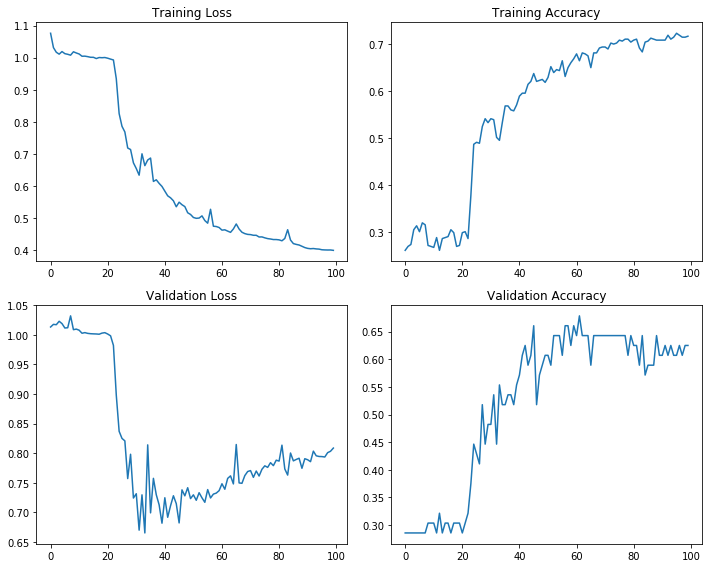

In [96]:
plt.figure(1, figsize=(10,8))
plt.subplot(221); plt.plot(training_loss); plt.title('Training Loss')
plt.subplot(222); plt.plot(training_accu); plt.title('Training Accuracy')
plt.subplot(223); plt.plot(validation_loss); plt.title('Validation Loss')
plt.subplot(224); plt.plot(validation_acc); plt.title('Validation Accuracy')
plt.tight_layout() 

 

In [99]:
with open(args.model_save, 'rb') as f:
  model_LSTM_test = LSTM()
  model_LSTM_test.load_state_dict(torch.load(f)) 
model_LSTM_test = model_LSTM_test.cuda()
model_LSTM_test = model_LSTM_test.eval()
test_LSTM = validate(model_LSTM_test, loader = test_loader)
 

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:54: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


    | end of validation epoch 100 | time:  0.21s | Accuracy 0.6786 | | Loss 0.7390 |
---------------------------------------------------------------------------------------------------
